In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge

from scipy.signal import savgol_filter
from transformations import euler_matrix

In [2]:
trajectory_file_path = '/home/sony/logs/angled_slice.npz'
time = 5
num_dims, num_basis, num_sensors = 7, 8, 2
alpha = 30.0
beta = alpha/4.0
tau = 0.15

In [3]:
trajectory_data = np.load(trajectory_file_path)
trajectory_times = trajectory_data['trajectory_times']
trajectory = trajectory_data['joint_trajectory']

In [4]:
def get_local_ref_frame_rot_mat(trajectory): 
    initial_trans = euler_matrix(trajectory[0, 3], trajectory[0, 4], trajectory[0, 5], 'szyx')
    R0 = initial_trans[:3,:3]
#     R_global_to_cut=np.array([[0.0,1.0,0.0],[1.0,0.0,0.0],[0.0,0.0,-1.0]])
#     R0=np.matmul(R_global_to_cut,np.transpose(R0)) #works for angledLR as well
    
    return R0

In [5]:
class DMPTrajectory(object):
    def __init__(self, tau, alpha, beta, num_dims, num_basis, num_sensors):
        self.tau = tau
        self.alpha = alpha
        self.beta = beta

        self.num_dims = num_dims
        self.num_basis = num_basis
        self.num_sensors = num_sensors

        self.mean = np.array([np.exp(-i * (0.5 / (self.num_basis - 1))) 
                for i in range(self.num_basis)])
        self.std = [0.5 / (0.65 * (self.mean[i+1]-self.mean[i])**2) 
                for i in range(self.num_basis - 1)]
        self.std += [self.std[-1]]
        self.std = np.array(self.std)
        # Get mu and h for all parameters separately
        self.mu_all = np.zeros((num_dims, num_sensors, num_basis))
        self.h_all = np.zeros((num_dims, num_sensors, num_basis))
        for i in range(num_dims):
            for j in range(num_sensors):
                self.mu_all[i, j] = self.mean
                self.h_all[i, j] = self.std

        self.phi_j = np.ones((self.num_sensors))

        print("Mean: {}".format(np.array_str(self.mean, precision=2,
            suppress_small=True, max_line_width=100)))
        print("Std: {}".format(np.array_str(self.std, precision=2,
            suppress_small=True, max_line_width=100)))
        # self.print_stuff()

    def print_stuff(self):
        NUM_DIM,  NUM_BASIS = self.num_dims, self.num_basis
        self.c = np.zeros([NUM_DIM, NUM_BASIS])
        self.h = np.zeros([NUM_DIM, NUM_BASIS])
        for i in range(NUM_DIM):
            for j in range(1,NUM_BASIS+1):
                self.c[i,j-1] = np.exp(-(j - 1) * 0.5/(NUM_BASIS - 1))
            for j in range(1,NUM_BASIS):
                self.h[i,j-1] = 0.5 / (0.65 * (self.c[i,j] - self.c[i,j-1])**2)
            self.h[i,NUM_BASIS-1] = self.h[i,NUM_BASIS-2]
        print("Mean: {}".format(np.array_str(self.c[0], precision=2,
            suppress_small=True, max_line_width=100)))
        print("Std: {}".format(np.array_str(self.h[0], precision=2,
            suppress_small=True, max_line_width=100)))

    def get_x_values(self, dt, x_start=1.0):
        x_list = [x_start]
        for _ in range(dt.shape[0]-1):
            dx = -(self.tau * x_list[-1])
            x = x_list[-1] + dx*dt[-1]
            if x < (self.mean[-1] - 3.0*np.sqrt(1.0/self.std[-1])):
                x = 1e-7
            x_list.append(x)
        return np.array(x_list).astype('float64')

    def get_t_values(self, dt, t_start=0.0):
        t_list = [t_start]
        for i in range(dt.shape[0] - 1):
            t_list.append(t_list[-1] + dt[i])
        return np.array(t_list/t_list[-1]).astype('float64')

    def convert_joint_trajectory_to_joint_dmp_training_format(
            self, trajectory_times, trajectory, use_goal_formulation=False):
        
        num_trajectory_points = trajectory.shape[0]
        time = trajectory_times
        dt = time[1:] - time[:-1]
        
        assert np.min(dt) > 0.0 and np.max(dt) < 1.0, "Recorded time is far off"
        
        q = trajectory
        
        d_q = (q[1:, :] - q[:-1, :]) / dt

        for i in range(d_q.shape[1]):
            d_q[:, i] = savgol_filter(d_q[:, i], 21, 5)

        # Repeat the last x to get equal length array.
        d_q = np.vstack([d_q, d_q[-1:, :]])
        dd_q = (d_q[1:, :] - d_q[:-1, :]) / dt

        # Repeat the last x to get equal length array.
        dd_q = np.vstack([dd_q, dd_q[-1:, :]])
        #print("dd_pos: max: {:.3f}, min: {:.3f}, mean: {:.3f}".format(
        #    dd_pos.min(), dd_pos.max(), np.mean(dd_pos)))
        #self.dpos_clone_list.append(d_pos.copy())
        #self.ddpos_clone_list.append(dd_pos.copy())
        
        y0 = q[0]

        force_val = dd_q/(self.tau**2) - self.alpha*(self.beta*(y0-q) \
                - d_q/self.tau)
        force_val = force_val/(self.alpha*self.beta)
        # Get the x values
        x_arr = self.get_x_values(dt)
        # Repeat the last x to get equal length array. Shape (T)
        x_arr = np.hstack([x_arr, x_arr[-1:]])

        # x_arr will be of shape (T, N, M, K)
        for _, axis_size in enumerate(
                [self.num_dims, self.num_sensors, self.num_basis]):
            x_arr = np.repeat(x_arr[..., None], axis_size, axis=-1)
        assert x_arr.shape == \
          (time.shape[0], self.num_dims, self.num_sensors, self.num_basis)

        psi_tijk = np.exp(-self.h_all * (x_arr - self.mu_all)**2)
        psi_tij_sum = np.sum(psi_tijk, axis=-1, keepdims=True)

        feat_tijk = (psi_tijk * x_arr) / (psi_tij_sum + 1e-10)

        # Get the minimum jerk features
        min_jerk_t = np.minimum(-np.log(x_arr[:,:,:,0:1])*2,
                                np.ones(x_arr[:,:,:,0:1].shape))
        feat_min_jerk_tijk = (min_jerk_t**3)*(6*(min_jerk_t**2)-15*min_jerk_t+10)

        feat_tijk = np.concatenate([feat_min_jerk_tijk, feat_tijk], axis=-1)

        # use displace (g - y0) as phi_j where j = 0
        if use_goal_formulation:
            # calculate (g - y0)
            f_shape = feat_tijk.shape
            q_delta = q[-1, :] - q[0, :]
            phi_ij = np.ones((f_shape[1], f_shape[2]))
            # phi_ij[-1, 0] = pos_delta[-1]
            phi_ij[:, 0] = q_delta
            print("phi_0 is {}".format(q_delta))
            phi_ijk = np.tile(phi_ij[:, :, np.newaxis], (1, 1, f_shape[3]))
            phi_tijk = np.tile(phi_ijk[np.newaxis, ...], (f_shape[0], 1, 1, 1))
            feat_tijk = feat_tijk * phi_tijk

        # This reshape happens according to "C" order, i.e., last axis change
        # first, this means that 1400 parameters are laid according to each
        # dim.
        X = feat_tijk.copy().reshape(x_arr.shape[0], self.num_dims, -1)
        y = force_val.copy()
        assert X.shape[0] == y.shape[0], "X, y n_samples do not match"
        assert X.shape[1] == y.shape[1], "X, y n_dims do not match"

        # X^T\beta = y (where we have to find \beta)

        return {'X': X, 'y': y}
    
    def convert_pose_trajectory_to_pose_dmp_training_format(
            self, trajectory_times, trajectory, local_frame=False, use_goal_formulation=False):

        num_trajectory_points = trajectory.shape[0]
        time = trajectory_times
        dt = time[1:] - time[:-1]

        assert np.min(dt) > 0.0 and np.max(dt) < 1.0, "Recorded time is far off"
        
        ph=np.empty((0,3))      

        ang=None
        
        #####added to allow to change to local reference frame
        if local_frame:       
            print('local_frame',local_frame)    

            R0=get_local_ref_frame_rot_mat(trajectory)
            pos=np.transpose(np.matmul(R0,np.transpose(trajectory[:, :3])))   
            
            for i in range(num_trajectory_points):        
                print('getting localRefFrame data')  
                #print('getting global RefFrame data')
                current_trans = euler_matrix(trajectory[i, 3], trajectory[i, 4], trajectory[i, 5], 'szyx')
                R = current_trans[:3,:3]              
                R_transformed=np.matmul(R0,R)
                
                R4 = trajectory[i,:3].reshape((3,1))
                R_transformed=np.concatenate((R_transformed,R4),axis=1) #3x4  
                R_transformed=np.concatenate((R_transformed,np.array([[0,0,0,1]])),axis=0) #4x4           

                zyx=np.array([(euler_from_matrix(R_transformed, axes='szyx'))])    
             
                ph= np.vstack([ph, zyx]) #tx3 matrix of euler angles
                ang=ph
            pos = np.hstack([pos,ang])
        else: 
            pos = trajectory

        #self.pos_clone_list.append(np.copy(pos))

        # Get velocity and acceleration.
        d_pos = (pos[1:, :] - pos[:-1, :]) / dt

        for i in range(d_pos.shape[1]):
            d_pos[:, i] = savgol_filter(d_pos[:, i], 21, 5)


        # Repeat the last x to get equal length array.
        d_pos = np.vstack([d_pos, d_pos[-1:, :]])
        dd_pos = (d_pos[1:, :] - d_pos[:-1, :]) / dt

        # Repeat the last x to get equal length array.
        dd_pos = np.vstack([dd_pos, dd_pos[-1:, :]])
        #print("dd_pos: max: {:.3f}, min: {:.3f}, mean: {:.3f}".format(
        #    dd_pos.min(), dd_pos.max(), np.mean(dd_pos)))
        #self.dpos_clone_list.append(d_pos.copy())
        #self.ddpos_clone_list.append(dd_pos.copy())
        
        y0 = pos[0]

        force_val = dd_pos/(self.tau**2) - self.alpha*(self.beta*(y0-pos) \
                - d_pos/self.tau)
        force_val = force_val/(self.alpha*self.beta)
        # Get the x values
        x_arr = self.get_x_values(dt)
        # Repeat the last x to get equal length array. Shape (T)
        x_arr = np.hstack([x_arr, x_arr[-1:]])

        # x_arr will be of shape (T, N, M, K)
        for _, axis_size in enumerate(
                [self.num_dims, self.num_sensors, self.num_basis]):
            x_arr = np.repeat(x_arr[..., None], axis_size, axis=-1)
        assert x_arr.shape == \
          (time.shape[0], self.num_dims, self.num_sensors, self.num_basis)

        psi_tijk = np.exp(-self.h_all * (x_arr - self.mu_all)**2)
        psi_tij_sum = np.sum(psi_tijk, axis=-1, keepdims=True)

        feat_tijk = (psi_tijk * x_arr) / (psi_tij_sum + 1e-10)

        # Get the minimum jerk features
        min_jerk_t = np.minimum(-np.log(x_arr[:,:,:,0:1])*2,
                                np.ones(x_arr[:,:,:,0:1].shape))
        feat_min_jerk_tijk = (min_jerk_t**3)*(6*(min_jerk_t**2)-15*min_jerk_t+10)

        feat_tijk = np.concatenate([feat_min_jerk_tijk, feat_tijk], axis=-1)

        # use displace (g - y0) as phi_j where j = 0
        if use_goal_formulation:
            # calculate (g - y0)
            f_shape = feat_tijk.shape
            pos_delta = pos[-1, :] - pos[0, :]
            phi_ij = np.ones((f_shape[1], f_shape[2]))
            # phi_ij[-1, 0] = pos_delta[-1]
            phi_ij[:, 0] = pos_delta
            print("phi_0 is {}".format(pos_delta))
            phi_ijk = np.tile(phi_ij[:, :, np.newaxis], (1, 1, f_shape[3]))
            phi_tijk = np.tile(phi_ijk[np.newaxis, ...], (f_shape[0], 1, 1, 1))
            feat_tijk = feat_tijk * phi_tijk

        # This reshape happens according to "C" order, i.e., last axis change
        # first, this means that 1400 parameters are laid according to each
        # dim.
        X = feat_tijk.copy().reshape(x_arr.shape[0], self.num_dims, -1)
        y = force_val.copy()
        assert X.shape[0] == y.shape[0], "X, y n_samples do not match"
        assert X.shape[1] == y.shape[1], "X, y n_dims do not match"

        # X^T\beta = y (where we have to find \beta)

        return {'X': X, 'y': y}


    #Calculate Euler angles from raw robot state data
    def convert_pose_trajectory_to_orientation_dmp_training_format(self, 
                                    trajectory_times, trajectory, local_frame=False, use_goal_formulation=False):
        num_trajectory_points = trajectory.shape[0]
        time = trajectory_times
        dt = time[1:] - time[:-1]

        assert np.min(dt) > 0.0 and np.max(dt) < 1.0, "Recorded time is far off"

        ph=np.empty((0,3))      

        ang=None
        
        # #########################ORIGINAL
        # #Get rotation matrix for each time point and use to calc 3 EulerAng for each time pt
        if local_frame:
            R0=get_local_ref_frame_rot_mat(trajectory)
            for i in range(num_trajectory_points):        
                print('getting localRefFrame data')  
                #print('getting global RefFrame data')
                current_trans = euler_matrix(trajectory[i, 3], trajectory[i, 4], trajectory[i, 5], 'szyx')
                R = current_trans[:3,:3]              
                R_transformed=np.matmul(R0,R)
                
                R4 = trajectory[i,:3].reshape((3,1))
                R_transformed=np.concatenate((R_transformed,R4),axis=1) #3x4  
                R_transformed=np.concatenate((R_transformed,np.array([[0,0,0,1]])),axis=0) #4x4           

                zyx=np.array([(euler_from_matrix(R_transformed, axes='szyx'))])    
             
                ph= np.vstack([ph, zyx]) #tx3 matrix of euler angles
                ang=ph
        else:
             ang=trajectory[:,3:]

        #self.ang_clone_list.append(np.copy(ang))

        # Get ang velocity and acceleration.
        d_ang = (ang[1:, :] - ang[:-1, :]) / dt 

        for i in range(d_ang.shape[1]):
            d_ang[:, i] = savgol_filter(d_ang[:, i], 21, 5) #Savitzsky-Golay filter for smoothing

        # Repeat the last x to get equal length array.
        d_ang = np.vstack([d_ang, d_ang[-1:, :]])
        dd_ang = (d_ang[1:, :] - d_ang[:-1, :]) / dt

        # Repeat the last x to get equal length array.
        dd_ang = np.vstack([dd_ang, dd_ang[-1:, :]])
        #print("dd_ang: max: {:.3f}, min: {:.3f}, mean: {:.3f}".format(
        #    dd_ang.min(), dd_ang.max(), np.mean(dd_ang)))
        #self.dang_clone_list.append(d_ang.copy())
        #self.ddang_clone_list.append(dd_ang.copy())

        y0 = ang[0]

        force_val = dd_ang/(self.tau**2) - self.alpha*(self.beta*(y0-ang) \
                - d_ang/self.tau)
        force_val = force_val/(self.alpha*self.beta)
        # Get the x values
        x_arr = self.get_x_values(dt)
        # Repeat the last x to get equal length array. Shape (T)
        x_arr = np.hstack([x_arr, x_arr[-1:]])

        # x_arr will be of shape (T, N, M, K)
        for _, axis_size in enumerate(
                [self.num_dims, self.num_sensors, self.num_basis]):
            x_arr = np.repeat(x_arr[..., None], axis_size, axis=-1)
        assert x_arr.shape == \
          (time.shape[0], self.num_dims, self.num_sensors, self.num_basis)

        psi_tijk = np.exp(-self.h_all * (x_arr - self.mu_all)**2)
        psi_tij_sum = np.sum(psi_tijk, axis=-1, keepdims=True)

        feat_tijk = (psi_tijk * x_arr) / (psi_tij_sum + 1e-10)

        # Get the minimum jerk features
        min_jerk_t = np.minimum(-np.log(x_arr[:,:,:,0:1])*2,
                                np.ones(x_arr[:,:,:,0:1].shape))
        feat_min_jerk_tijk = (min_jerk_t**3)*(6*(min_jerk_t**2)-15*min_jerk_t+10)

        feat_tijk = np.concatenate([feat_min_jerk_tijk, feat_tijk], axis=-1)

        # use displace (g - y0) as phi_j where j = 0
        if use_goal_formulation:
            # calculate (g - y0)
            f_shape = feat_tijk.shape
            pos_delta = pos[-1, :] - pos[0, :]
            phi_ij = np.ones((f_shape[1], f_shape[2]))
            # phi_ij[-1, 0] = pos_delta[-1]
            phi_ij[:, 0] = pos_delta
            print("phi_0 is {}".format(pos_delta))
            phi_ijk = np.tile(phi_ij[:, :, np.newaxis], (1, 1, f_shape[3]))
            phi_tijk = np.tile(phi_ijk[np.newaxis, ...], (f_shape[0], 1, 1, 1))
            feat_tijk = feat_tijk * phi_tijk

        # This reshape happens according to "C" order, i.e., last axis change
        # first, this means that 1400 parameters are laid according to each
        # dim.
        X_ang = feat_tijk.copy().reshape(x_arr.shape[0], self.num_dims, -1)
        y_ang = force_val.copy()
        assert X_ang.shape[0] == y_ang.shape[0], "X_ang, y_ang n_samples do not match"
        assert X_ang.shape[1] == y_ang.shape[1], "X_ang, y_ang n_dims do not match"

        # X^T\beta = y (where we have to find \beta)

        return {'X_ang': X_ang, 'y_ang': y_ang}

    def run_dmp_with_weights(self, weights, y0, dt, traj_time=100,  phi_j=None):
        '''Run DMP with given weights.
        weights: array of weights. size: (N*M*K, 1) i.e. 
            (num_dims*num_sensors*num_basis, 1)
        y0: Start location for dmps. Array of size (N,)
        dt: Time step to use. Float.
        traj_time: Time length to sample trajectories. Integer
        '''
        x = 1.0
        y  = np.zeros((traj_time, self.num_dims))
        dy = np.zeros((traj_time, self.num_dims))
        y[0] = y0
        # This reshape happens along the vector i.e. the first (M*K) values 
        # belong to dimension 0 (i.e. N = 0). Following (M*K) values belong to
        # dimension 1 (i.e. N = 1), and so forth.
        # NOTE: We add 1 for the weights of the jerk basis function

        min_jerk_arr = np.zeros((traj_time))

        x_log = []
        psi_log = []
        min_jerk_log = []
        for i in range(traj_time - 1):
            # psi_ijk is of shape (N, M, K)
            psi_ijk = np.exp(-self.h_all * (x-self.mu_all)**2)

            psi_ij_sum = np.sum(psi_ijk, axis=2, keepdims=True)



            f = (psi_ijk * weights[:, :, 1:] * x).sum(
                    axis=2, keepdims=True) / (psi_ij_sum + 1e-10)
            # f_min_jerk = (i * dt)/(traj_time * dt)
            f_min_jerk = min(-np.log(x)*2, 1)
            f_min_jerk = (f_min_jerk**3)*(6*(f_min_jerk**2) - 15*f_min_jerk+ 10)
            psi_ij_jerk = weights[:, :, 0:1] * f_min_jerk

            # for debug
            min_jerk_arr[i] = f_min_jerk

            # calculate f(x; w_j)l -- shape (N, M)
            all_f_ij = self.alpha * self.beta * (f + psi_ij_jerk).squeeze()

            # Calculate sum_j(phi_j * f(x; w_j) -- shape (N,)
            
            if phi_j is None:
                phi_j = self.phi_j

            #ORIGINAL CODE
            # if len(phi_j.shape) == 1:
            #     all_f_i = np.dot(all_f_ij, phi_j) #Uncomment this if num sensors =2

            #     #all_f_i = np.dot((self.alpha * self.beta * (f + psi_ij_jerk)), phi_j) #comment out if num sensors=2 (updated to make matrix dims work for num sensors=1)
            #     #all_f_i=all_f_i.squeeze() #comment out if num sensors=2
            
            # elif len(phi_j.shape) == 2:
            #     all_f_i = np.sum(all_f_ij * phi_j, axis=1)
            # else:
            #     raise ValueError("Incorrect shape for phi_j")

            #10/31 update to fix issue and make it work if num sensors is 1 or 2:
            if phi_j.shape == (1,):
                #all_f_i = np.dot(all_f_ij, phi_j) #Uncomment this if num sensors =2

                all_f_i = np.dot((self.alpha * self.beta * (f + psi_ij_jerk)), phi_j) #comment out if num sensors=2 (updated to make matrix dims work for num sensors=1)
                all_f_i=all_f_i.squeeze() #comment out if num sensors=2
            
            elif phi_j.shape == (2,):
                #all_f_i = np.sum(all_f_ij * phi_j, axis=1)
                all_f_i = np.dot(all_f_ij, phi_j) #Uncomment this if num sensors =2
            else:
                raise ValueError("Incorrect shape for phi_j")
            ###end 10/31 update

            
            ddy = self.alpha*(self.beta*(y0 - y[i]) - dy[i]/self.tau) + all_f_i
            ddy = ddy * (self.tau ** 2)
            dy[i+1] = dy[i] + ddy * dt
            y[i+1] = y[i] + dy[i+1] * dt

            x_log.append(x)
            psi_log.append(psi_ijk)
            min_jerk_log.append(f_min_jerk)

            x += ((-self.tau * x) * dt)
            if (x < self.mean[-1] - 3.0*np.sqrt(1.0/(self.std[-1]))):
                x = 1e-7

        return y, dy, x_log, np.array(psi_log), np.array(min_jerk_log)


    def train(self, X_train, y_train, X_test, y_test, use_ridge=False,
              fit_intercept=True):
        reg_lambda = 0.01
        if use_ridge:
            clf = Ridge(alpha=reg_lambda,
                        fit_intercept=fit_intercept).fit(X_train, y_train)
            train_score = clf.score(X_train, y_train)
            test_score = clf.score(X_test, y_test)
        else:
            clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1],
                          fit_intercept=fit_intercept).fit(X_train, y_train)
            train_score = clf.score(X_train, y_train)
            test_score = clf.score(X_test, y_test)
        y_pred = clf.predict(X_train)
        print("Score (max 1.0) Train: {:.3f}, Test: {:.3f}".format(
            train_score, test_score))

        M = np.linalg.inv(np.dot(X_train.T, X_train) + 
                          reg_lambda*np.eye(X_train.shape[1]))
        N = np.dot(X_train.T, y_train)
        weights = np.dot(M, N)
        ridge_weights = clf.coef_
        preds = np.dot(X_train, weights)
        self.train_clf_preds = y_pred.copy()
        self.train_preds = preds.copy()
        self.train_gt = y_train.copy()
        print("Error in pred: {:.6f}".format(
            np.linalg.norm(preds - y_train)/y_train.shape[0]))

        return clf

    def save_weights(self, save_path, weights, **kwargs):
        mean = [0.0] + self.mean.tolist()
        std = [0.0] + self.std.tolist()
        phi_j_list = self.phi_j.tolist()
        weights_list = weights.tolist()

        data_dict = {
            'tau': self.tau,
            'alpha': self.alpha,
            'beta': self.beta,
            'num_dims': self.num_dims,
            'num_basis': self.num_basis+1, # +1 for the minimum jerk trajectory
            'num_sensors': self.num_sensors,
            'mu': mean,
            'h': std,
            'phi_j': phi_j_list,
            'weights': weights_list,
        }
        for k, v in kwargs.items():
            data_dict[k] = v

        with open(save_path, 'wb') as pkl_f:
            pickle.dump(data_dict, pkl_f, protocol=2)
            print("Did save dmp params: {}".format(save_path))

    def save_weights_csv(self,filename,weights):
        data=weights
        print('shape weights is ', data.shape)
        print(data)

        with open(filename, 'w') as outfile:

            #outfile.write('# Array shape: {0}\n'.format(data.shape))

            #for data_slice in data:  #produces slices for each x, y, z dimension
            for i in range(0,data.shape[0]):    
                #print(data_slice)
                print(i)
                data_slice=data[i,:,:]
                print(data[i,:,:])

                np.savetxt(outfile, data_slice, fmt='%-10.8f', delimiter=' ')               


                #outfile.write('# New slice\n')
            #a=open(filename,'r')
            #print('file contains')
            #print(a.read())

        #print("Saved weights to csv")

In [6]:
def train_joint_individual_trajectory(dmp_traj, trajectory_times, trajectory, use_goal_formulation=False):
    X, y, min_jerk_wi0 = [], [], []

    data = dmp_traj.convert_joint_trajectory_to_joint_dmp_training_format(
        trajectory_times, trajectory, use_goal_formulation=use_goal_formulation)

    assert (type(data['X']) is np.ndarray
            and type(data['y']) is np.ndarray), "Incorrect data type returned"

    X.append(data['X'])
    y.append(data['y'])

    # Get train and test dataa?
    X, y = np.concatenate(X, axis=0), np.concatenate(y, axis=0)

    train_size = int(X.shape[0] * 1.0)
    print("Train size: {} Test size: {}".format(train_size, 
                                                X.shape[0]-train_size))

    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[:train_size], y[:train_size]

    # Train a classifier separately for each dimension.
    weights = []
    for i in range(dmp_traj.num_dims):
        clf = dmp_traj.train(X_train[:, i, :],
                             y_train[:, i],
                             X_test[:, i],
                             y_test[:, i], 
                             use_ridge=True,
                             fit_intercept=False)
        weights.append(clf.coef_.copy().squeeze())
        print("Got weights for dim: {}, min: {:.3f}, max: {:.3f}, avg: {:.3f}".
                format(i, weights[-1].min(),
                       weights[-1].max(), weights[-1].mean()))

    weights_ijk = np.array([
        np.reshape(W, (dmp_traj.num_sensors, dmp_traj.num_basis+1))
        for W in weights])

    return weights_ijk, {'X': X, 'y': y}

In [7]:
def train_orientation_individual_trajectory(dmp_traj, trajectory_times, trajectory, local_frame=False, use_goal_formulation=False):
    X_ang, y_ang, min_jerk_wi0 = [], [], []

    data = dmp_traj.convert_pose_trajectory_to_orientation_dmp_training_format(
        trajectory_times, trajectory,local_frame=local_frame,
        use_goal_formulation=use_goal_formulation)

    assert (type(data['X_ang']) is np.ndarray
            and type(data['y_ang']) is np.ndarray), "Incorrect data type returned"

    X_ang.append(data['X_ang'])
    y_ang.append(data['y_ang']) #indent up through this line under for loop

    # Get train and test data?
    X_ang, y_ang = np.concatenate(X_ang, axis=0), np.concatenate(y_ang, axis=0)

    train_size = int(X_ang.shape[0] * 1.0)
    print("Train size: {} Test size: {}".format(train_size, 
                                                X_ang.shape[0]-train_size))

    X_ang_train, y_ang_train = X_ang[:train_size], y_ang[:train_size]
    X_ang_test, y_ang_test = X_ang[:train_size], y_ang[:train_size]

    # Train a classifier separately for each dimension.
    weights = []
    for i in range(dmp_traj.num_dims):
        clf = dmp_traj.train(X_ang_train[:, i, :],
                             y_ang_train[:, i],
                             X_ang_test[:, i],
                             y_ang_test[:, i], 
                             use_ridge=True,
                             fit_intercept=False)
        weights.append(clf.coef_.copy().squeeze())
        print("Got weights for dim: {}, min: {:.3f}, max: {:.3f}, avg: {:.3f}".
                format(i, weights[-1].min(),
                       weights[-1].max(), weights[-1].mean()))

    weights_ijk = np.array([
        np.reshape(W, (dmp_traj.num_sensors, dmp_traj.num_basis+1))
        for W in weights])

    return weights_ijk, {'X_ang': X_ang, 'y_ang': y_ang}   

In [8]:
dmp_traj = DMPTrajectory(tau, alpha, beta, num_dims, num_basis, num_sensors)

Mean: [1.   0.93 0.87 0.81 0.75 0.7  0.65 0.61]
Std: [161.86 186.72 215.39 248.47 286.63 330.64 381.42 381.42]


In [9]:
weights, x_and_y = train_joint_individual_trajectory(dmp_traj, trajectory_times, trajectory)

Train size: 3299 Test size: 0
Score (max 1.0) Train: 0.034, Test: 0.034
Error in pred: 0.001981
Got weights for dim: 0, min: -0.107, max: 0.170, avg: 0.044
Score (max 1.0) Train: 0.037, Test: 0.037
Error in pred: 0.002354
Got weights for dim: 1, min: -0.099, max: 0.165, avg: 0.003
Score (max 1.0) Train: 0.013, Test: 0.013
Error in pred: 0.001890
Got weights for dim: 2, min: -0.234, max: 0.110, avg: -0.059
Score (max 1.0) Train: 0.062, Test: 0.062
Error in pred: 0.004012
Got weights for dim: 3, min: -0.355, max: 0.278, avg: -0.029
Score (max 1.0) Train: 0.025, Test: 0.025
Error in pred: 0.001513
Got weights for dim: 4, min: -0.077, max: 0.105, avg: 0.014
Score (max 1.0) Train: 0.002, Test: 0.002
Error in pred: 0.002014
Got weights for dim: 5, min: -0.032, max: 0.097, avg: 0.018
Score (max 1.0) Train: 0.035, Test: 0.035
Error in pred: 0.004483
Got weights for dim: 6, min: -0.584, max: 0.257, avg: -0.096


In [15]:
y, dy, _, _, _ = dmp_traj.run_dmp_with_weights(weights,
                                      np.zeros((dmp_traj.num_dims)),
                                      0.001,
                                      traj_time=3300)

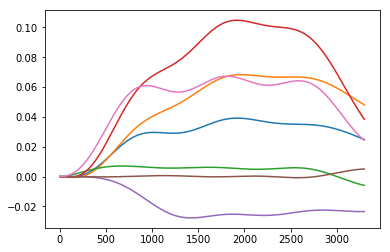

In [16]:
plt.plot(y)
plt.show()

In [17]:
def visualize_relative_cartesian_pose_trajectories(trajectory_times, trajectory, labels=['x','y','z','rx','ry','rz']):
    
    for i in range(6):
        plt.plot(trajectory_times, trajectory[:,i] - trajectory[0,i], label=labels[i])
    plt.legend()
    plt.title('Relative Cartesian Pose')
    plt.xlabel('Time (s)')
    plt.ylabel('Position (m) and Angle (rad)')
    plt.show()

def visualize_relative_joint_trajectories(trajectory_times, trajectory, labels=['1','2','3','4','5','6','7']):
    
    for i in range(len(labels)):
        plt.plot(trajectory_times, trajectory[:,i] - trajectory[0,i], label=labels[i])
    plt.legend()
    plt.title('Relative Joint Position')
    plt.xlabel('Time (s)')
    plt.ylabel('Position (rad)')
    plt.show()

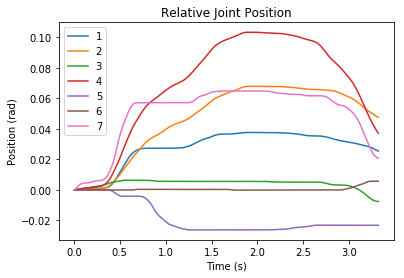

In [18]:
visualize_relative_joint_trajectories(trajectory_times, trajectory)

In [14]:
dmp_traj.save_weights(trajectory_file_path[:-4]+'_joint_weights.pkl', weights)

Did save dmp params: /home/sony/logs/angled_slice_joint_weights.pkl
